# Routing in LangGraph

## Definition

Routing in LangGraph is a workflow control mechanism that determines which node or path to execute next based on current state, user input, or specific conditions.

## Core Concept

Routing acts as a decision-making system that evaluates inputs and directs the flow to appropriate nodes, enabling dynamic navigation through different conversation paths or processing workflows.


In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=ChatOpenAI(model="gpt-4o-mini")

result=llm.invoke("What is the capital of France?")
print(result.content)

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CUqsgyNjgAsesccI405dhYVvLG33d', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--105f11b9-b884-4198-b0fd-4dbcfe4877fe-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

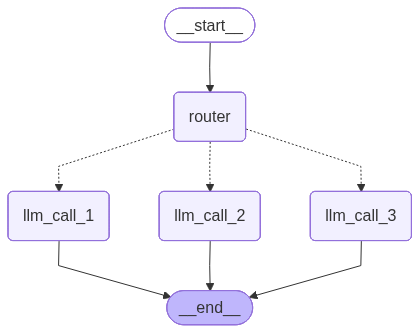

In [14]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

##Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")


##Augment the LLM with schema for structured output
router=llm.with_structured_output(Route)

##State
class State(TypedDict):
    input:str
    descision:str
    output:str

#Nodes
def llm_call_1(state:State):
    """Story"""
    print("LLM call 1 is called")
    result=llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_2(state:State):
    """Joke"""
    print("LLM call 2 is called")
    result=llm.invoke(state["input"])
    return {"output":result.content}


def llm_call_3(state:State):
    """Poem"""
    print("LLM call 3 is called")
    result=llm.invoke(state["input"])
    return {"output":result.content}



def llm_call_router(state:State):
    descision=router.invoke(
        [
            SystemMessage(content="Route the input to story,joke or poem based on the users request"),
            HumanMessage(content=state["input"])


        ]
    )
    return {"descision":descision.step}


def route_descision(state:State):
    if state["descision"]=="story":
        return "llm_call_1"

    elif state["descision"]=="joke":
        return "llm_call_2"

    elif state["descision"]=="poem":
        return "llm_call_3"


from langgraph.graph import StateGraph,START,END
from IPython.display import Image
#Build the Workflow
router_builder=StateGraph(State)


router_builder.add_node("llm_call_1",llm_call_1)
router_builder.add_node("llm_call_2",llm_call_2)
router_builder.add_node("llm_call_3",llm_call_3)
router_builder.add_node("router",llm_call_router)

router_builder.add_edge(START,"router")
router_builder.add_conditional_edges(
    "router",
    route_descision,
    {
        #Name returned by route descision : Name of next node to visit
        "llm_call_1":"llm_call_1",
        "llm_call_2":"llm_call_2",
        "llm_call_3":"llm_call_3",
    },
)

router_builder.add_edge("llm_call_1",END)
router_builder.add_edge("llm_call_2",END)
router_builder.add_edge("llm_call_3",END)

router_graph=router_builder.compile()

# Visualize the graph
Image(router_graph.get_graph().draw_mermaid_png()) 








In [16]:
state=router_graph.invoke({"input":"Write me a joke about Agentic AI Systems"})
print(state["output"])

LLM call 2 is called
Why did the agentic AI system bring a ladder to work? 

Because it wanted to reach new levels of autonomy!
